In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchDatasets as ds
import networks as custNN
from torchvision.transforms import v2
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from torch.utils.data import DataLoader

sns.set_theme(style='whitegrid')

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['figure.dpi']= 300



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def manualSeed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

side = 28
base_dir = '/home/shashank/Code/gonihedric/'; data_dir = base_dir + "data/"

def visualize_reconstruction(model, data_loader, dim1, dim2):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze().reshape(dim1, dim1), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze().reshape(dim2, dim2), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()

def plotLosses(trainArr, testArr, epochs, minX, maxX):
    # Plotting the training and test losses
    plt.figure(figsize=(10, 5))
    plt.plot(trainArr, label='Train Loss', color='blue')
    plt.plot(testArr, label='Test Loss', color='orange')
    plt.hlines(y=testArr[20:].mean(), xmin=0, xmax=epochs-1, color='red', linestyle='--', label='Threshold')
    plt.title(f"Minimum test loss: {np.min(testArr[minX:maxX])} at epoch: {np.argmin(testArr[minX:maxX])+minX}")
    plt.plot(np.argmin(testArr[minX:maxX])+minX, testArr[np.argmin(testArr[minX:maxX])+minX], 'g.',label='Min Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(minX, maxX)
    # plt.ylim(np.min(trainArr), np.max(testArr[20:])+0.001)
    plt.legend()
    # plt.grid()
    # plt.savefig(data_dir + "checkpoints/Autoencoder/loss_plot.png")
    plt.show()


def trainAndTest(model, trainLoader, testLoader, criterion, optimizer, num_epochs=10, saving=False):
    # Get current date and time
    now = datetime.now()
    folder_name = data_dir+"checkpoints/Autoencoder/"+now.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the folder
    os.makedirs(folder_name, exist_ok=True)

    trainLosses = np.empty(num_epochs)
    testLosses = np.empty(num_epochs)
    for epoch in range(num_epochs):
        model.train()
        # Iterate over data.
        total_loss = 0
        for batch_idx, (images, _) in enumerate(trainLoader):
            # Move images to device
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        trainLosses[epoch] = total_loss / len(trainLoader)
        model.eval()
        with torch.no_grad():
            total_loss = 0
            for batch_idx, (images, _) in enumerate(testLoader):
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images).cpu().numpy()
                total_loss += loss
            testLosses[epoch] = total_loss / len(testLoader)
        if epoch % 10 == 0 and saving:
            torch.save(model.state_dict(), folder_name+f"/model_epoch_{epoch}.pth")
    return trainLosses, testLosses

In [2]:
class AutoencoderCNN(nn.Module):
    def __init__(self, latent_dim=20):
        super(AutoencoderCNN, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        # Encode
        latent = self.encoder(x)

        # Decode
        reconstructed = self.decoder(latent)
        return reconstructed

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder: Convolutional layers to extract features
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: 32 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: 128 x 4 x 4
            nn.ReLU(),
            nn.Flatten(),  # Flatten the output to (batch_size, 128*4*4)
            nn.Linear(128*4*4, latent_dim)  # Latent dimension
        )
        
        # Decoder: Fully connected + Transposed convolutional layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),  # Latent to expanded shape
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),  # Unflatten to 128 x 4 x 4
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 64 x 7 x 7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 1 x 28 x 28
            nn.Sigmoid()  # Sigmoid to get values between 0 and 1
        )

    def forward(self, x):
        # Forward pass through the encoder and decoder
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Shape of images in trainLoader: torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


ValueError: cannot reshape array of size 784 into shape (32,32)

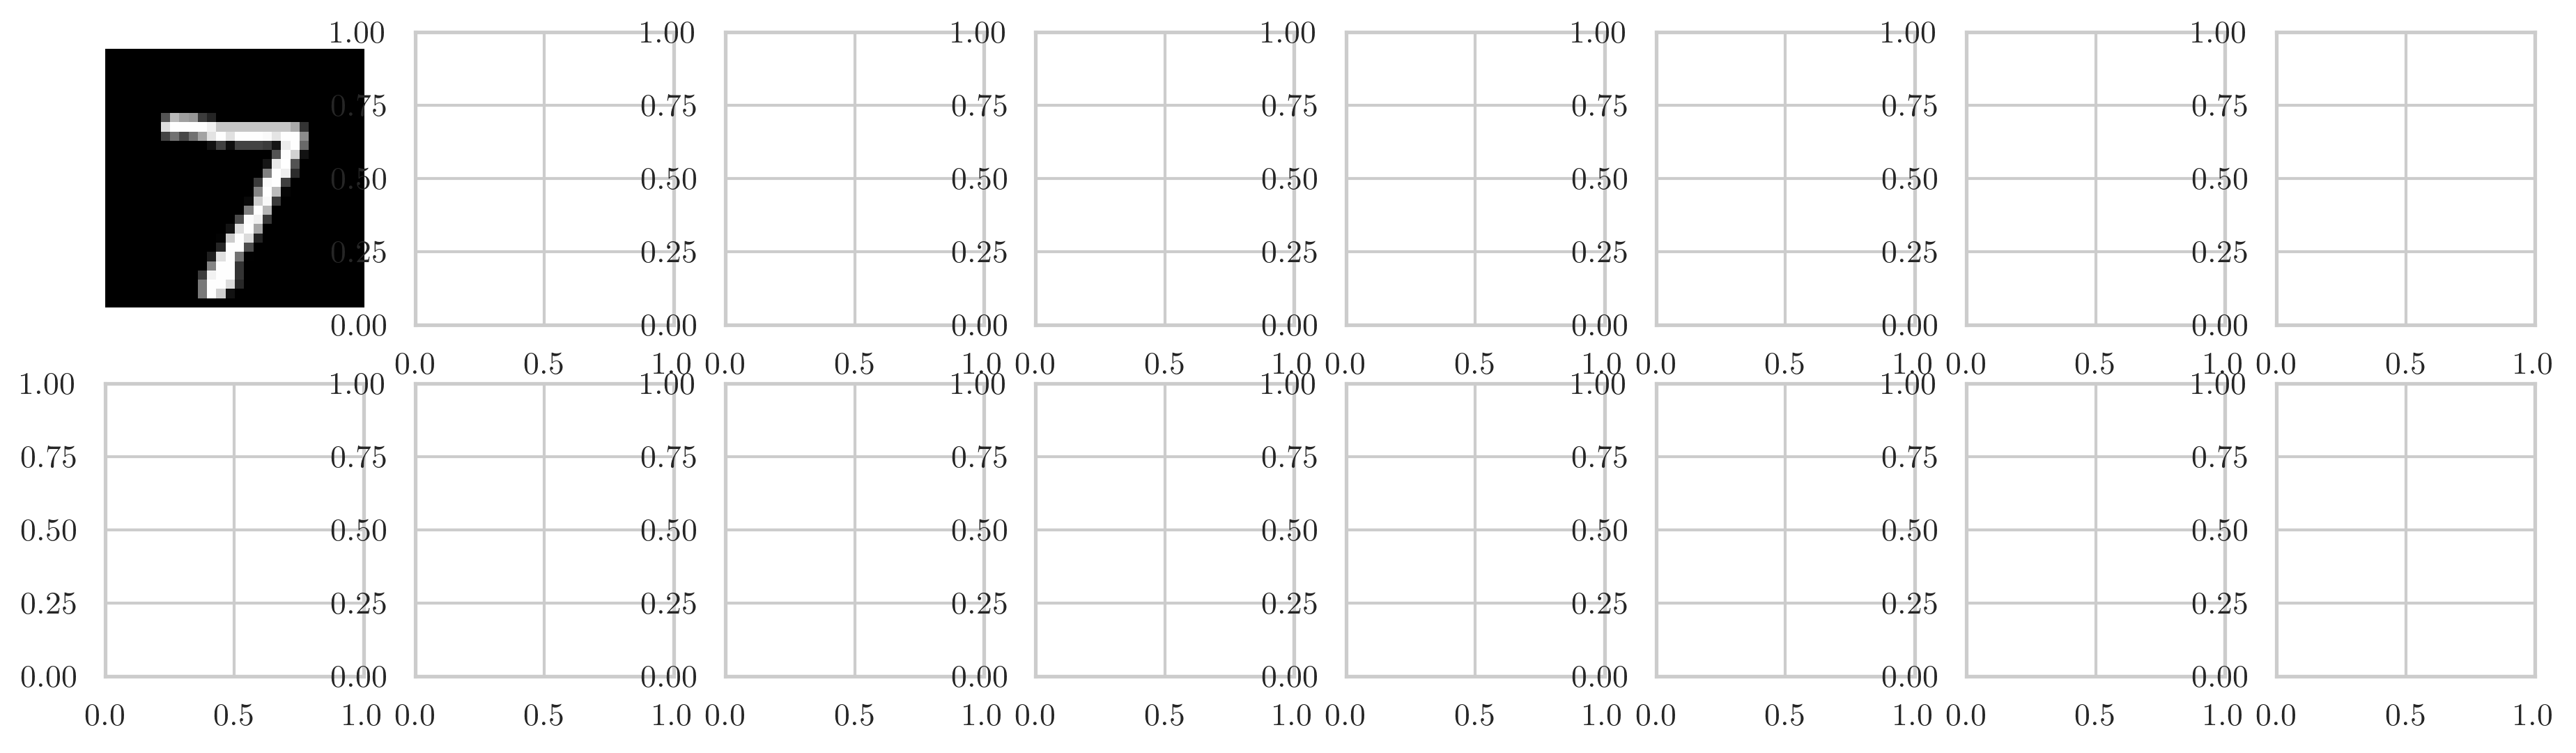

In [12]:
images, _ = next(iter(train_loader))
model = AutoencoderCNN().to(device)
print("Shape of images in trainLoader:",images.shape, model(images.to(device)).shape)
visualize_reconstruction(model, test_loader, 28, 32)

In [17]:
class upsamp_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(upsamp_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.Conv2d(4,16,3,padding=1)
        self.de_conv2=nn.Conv2d(16,1,3,padding=1)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.relu(self.de_conv1(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.sigmoid(self.de_conv2(x))
        return x

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            # nn.Linear(200, 100),
            # nn.ReLU(),
            nn.Linear(200, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            # nn.ReLU(),
            # nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten input
        x = x.view(x.size(0), -1)
        
        # Get latent representation
        latent = self.encoder(x)

        # Reconstruct input
        reconstructed = self.decoder(latent)

        # Reshape to original dimensions
        reconstructed = reconstructed.view(x.size(0), 1, 28, 28)
        return reconstructed

In [21]:
# Define transforms
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.Lambda(lambda x: 2*x - 1)
    # v2.Lambda(lambda x: torch.flatten(x, start_dim=1)),  # Flatten the image
    # v2.Normalize((0.1307,), (0.3081,)),
    # v2.Normalize((0.5,), (0.5,)),
    # v2.Lambda(lambda x: x.view(-1) - 0.5)
])


class ReshapeTransform:
    def __init__(self, shape):
        self.shape = shape
    def __call__(self, x):
        return x.view(*self.shape)

# transform = v2.Compose([ReshapeTransform(([side*side])), v2.Lambda(lambda x: 2*x - 1)])
# transform = v2.Compose([
#     v2.ToImage(), 
#     v2.ToDtype(torch.float32, scale=True),
#     ReshapeTransform(([side*side])),
#     v2.Lambda(lambda x: 2*x - 1)
#     # v2.Lambda(lambda x: torch.flatten(x, start_dim=1)),  # Flatten the image
#     # v2.Normalize((0.1307,), (0.3081,)),
#     # v2.Normalize((0.5,), (0.5,)),
#     # v2.Lambda(lambda x: x.view(-1) - 0.5)
# ])
# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [22]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 60000
Test dataset size: 10000


In [23]:
seed = 483482923932993232
manualSeed(seed)

# Initialize model and move to device
# model = Autoencoder(20).to(device)
# model = upsamp_conv_Auto_MNIST().to(device)
# model = custNN.Autoencoder([28*28, 600, 450, 300, 150, 75, 20], nn.Tanh(), nn.Sigmoid()).to(device)
# model = AutoencoderCNN().to(device)
model = custNN.Autoencoder([784, 600, 450, 300, 150, 75, 30, 10, 2], nn.Tanh(), nn.Tanh()).to(device)
# Initialize weights
initialize_weights(model)

# Hyperparameters
batchSize = 32
num_epochs = 100
learning_rate = 0.01

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
images, _ = next(iter(train_loader))
minimum = 1; maximum = 0
for value in images[0].cpu().numpy().squeeze().reshape(28, 28):
    for i in value:
        if i != 0.0:
            if i < minimum:
                minimum = i
            if i > maximum:
                maximum = i
print("Minimum non-zero pixel value:", minimum)
print("Maximum pixel value:", maximum)

# model = ConvAutoencoder(28).to(device)
# print("Shape of images in trainLoader:",images.shape, model(images.to(device)).shape)
# visualize_reconstruction(model, test_loader, 28, 32)


Minimum non-zero pixel value: 0.019607844
Maximum pixel value: 0.9960785


In [94]:
trainArr1, testArr1 = trainAndTest(model, train_loader, test_loader, criterion, optimizer, num_epochs)
plotLosses(trainArr1, testArr1, epochs=num_epochs, minX=0, maxX=num_epochs-1)
visualize_reconstruction(model, test_loader, 28)

RuntimeError: The size of tensor a (32) must match the size of tensor b (28) at non-singleton dimension 3

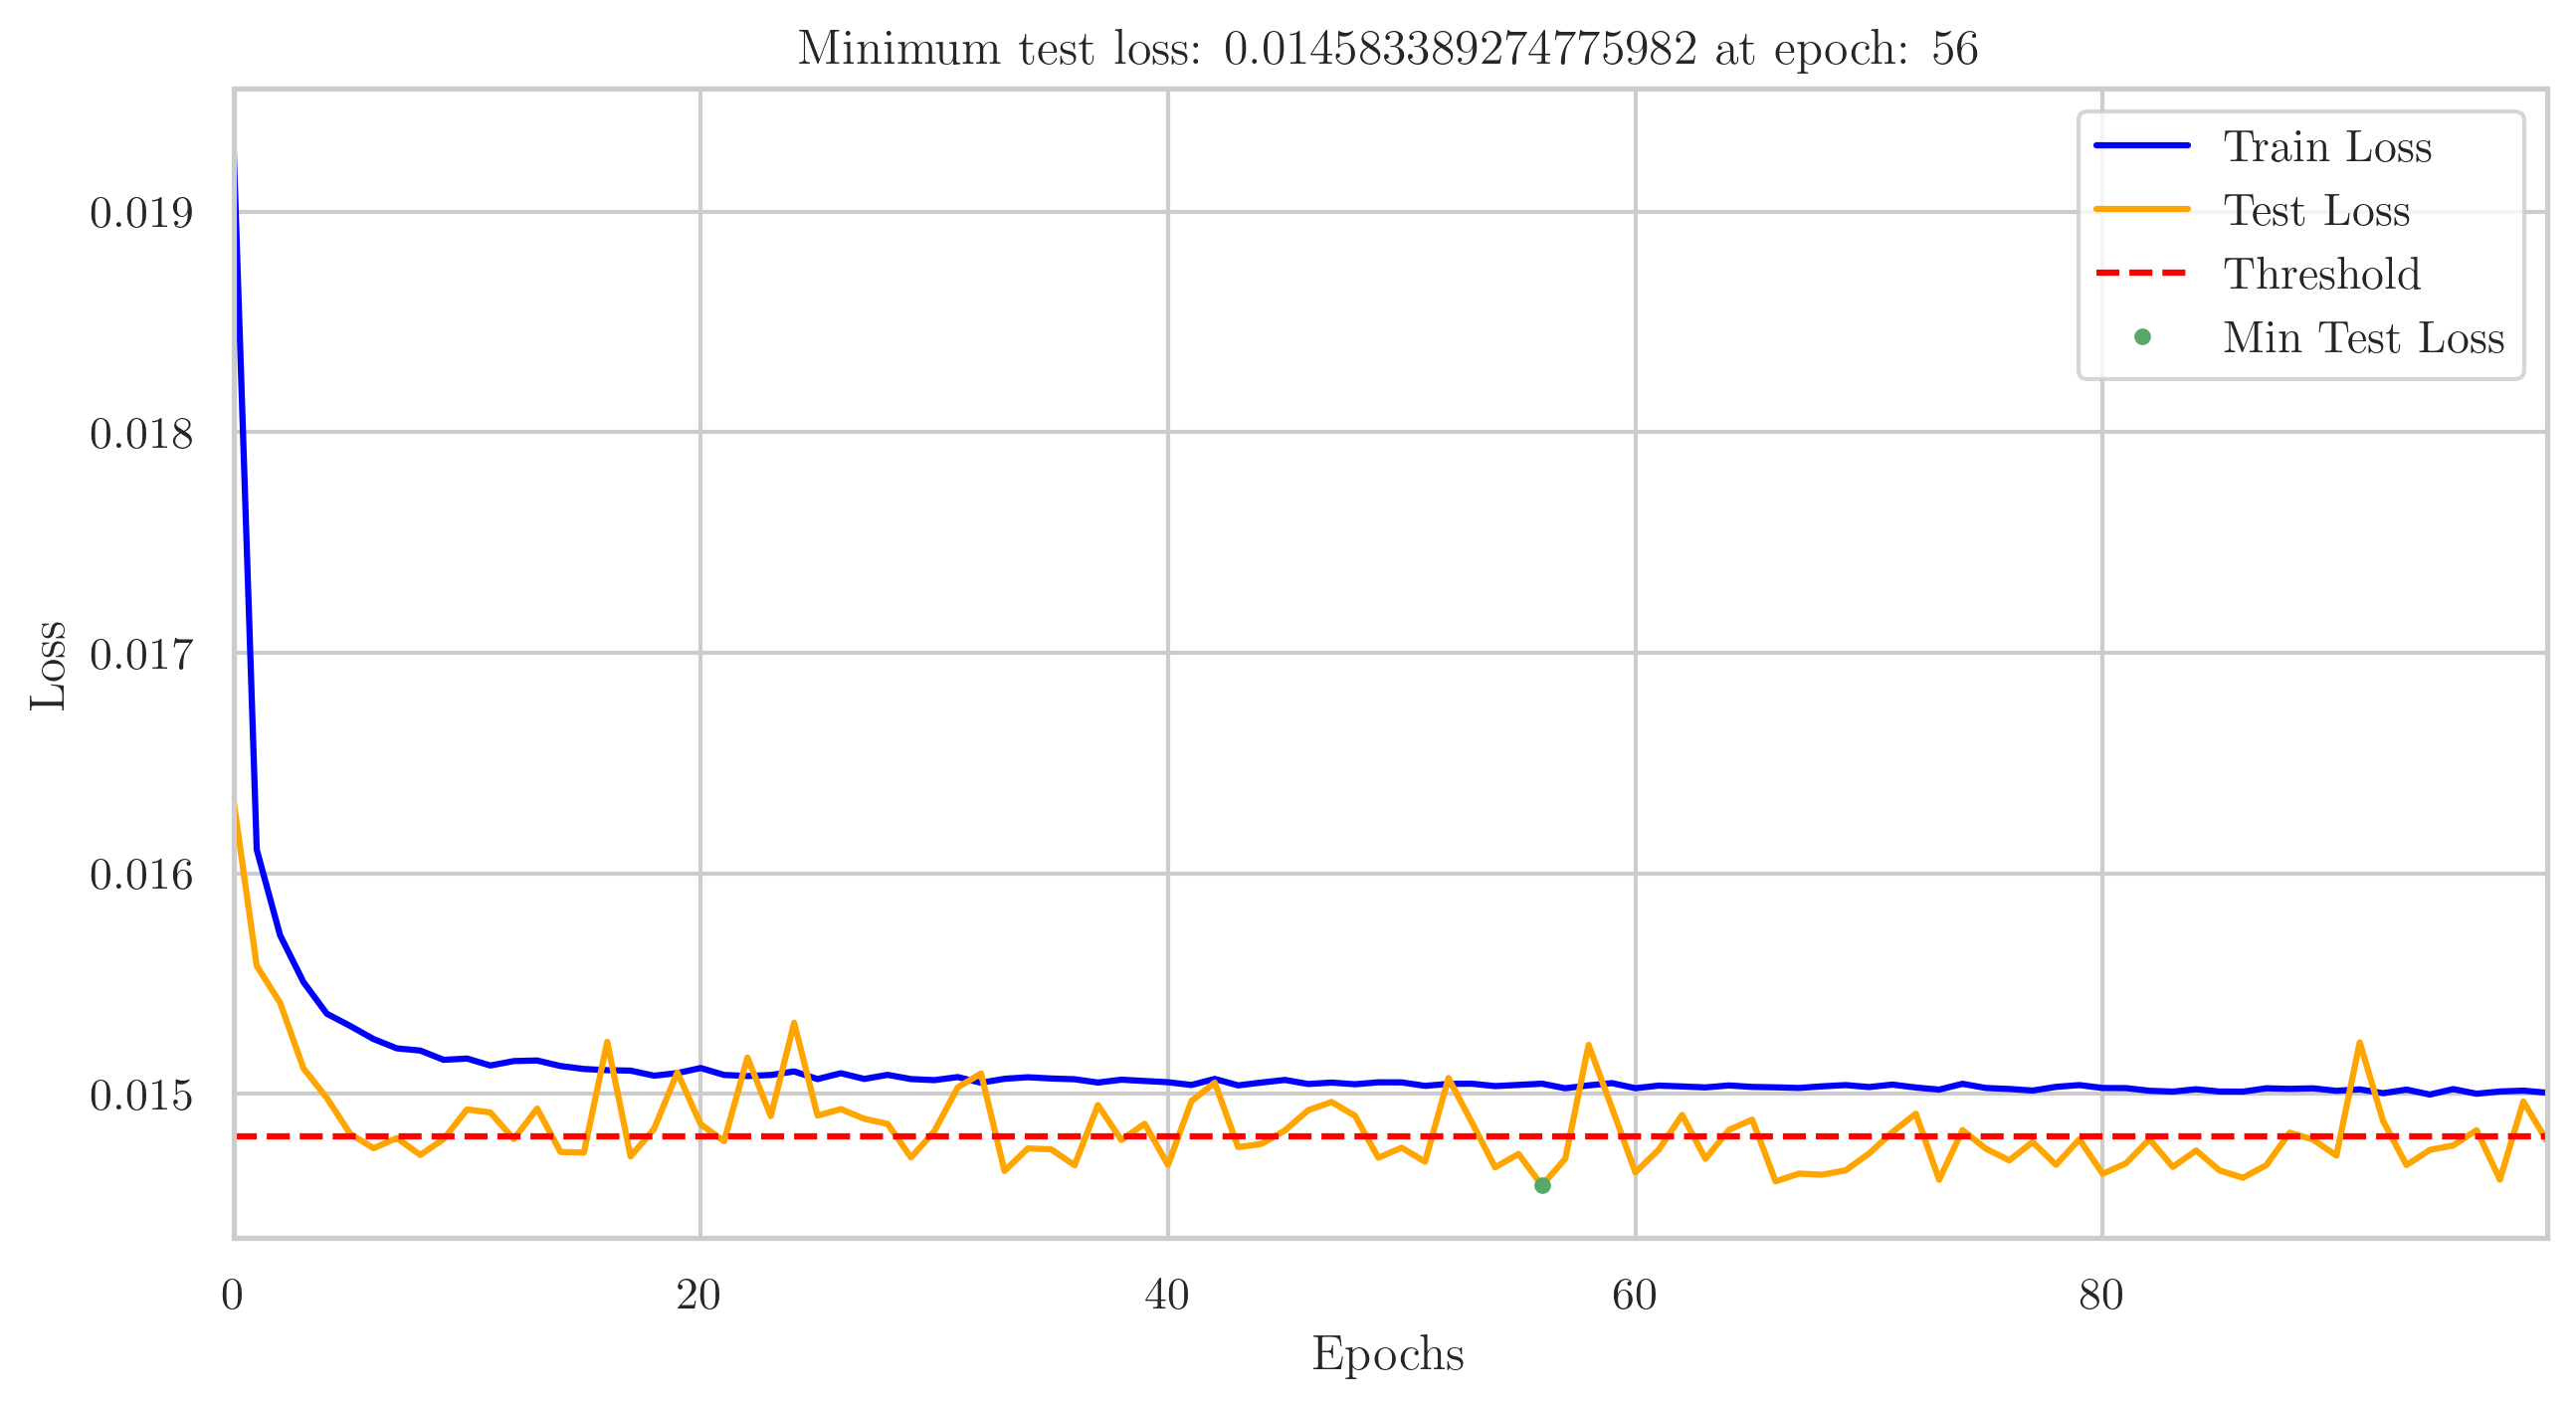

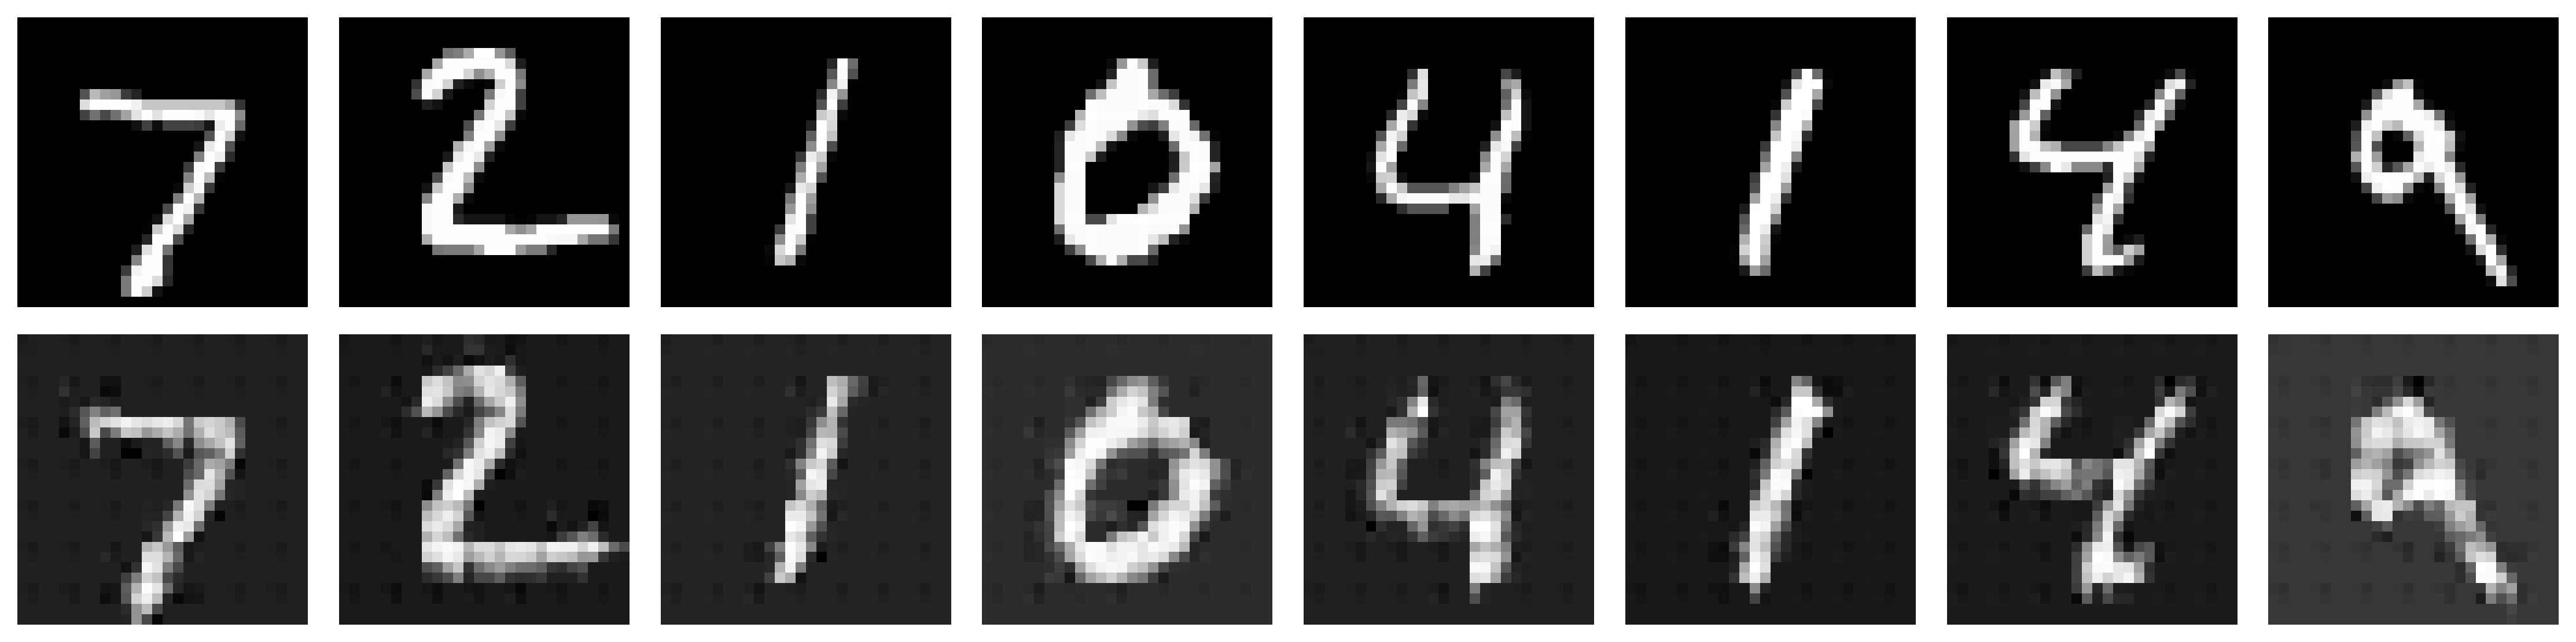

In [ ]:
trainArr1, testArr1 = trainAndTest(model, train_loader, test_loader, criterion, optimizer, num_epochs)
plotLosses(trainArr1, testArr1, epochs=num_epochs, minX=0, maxX=num_epochs-1)
visualize_reconstruction(model, test_loader, 28)

# seed = 483482923932993232
# manualSeed(seed)

# # Initialize model and move to device
# # model = Autoencoder(20).to(device)
# # model = upsamp_conv_Auto_MNIST().to(device)
# model = AutoencoderCNN().to(device)
# # model = custNN.Autoencoder([784, 600, 450, 300, 150, 75, 20], nn.Tanh(), nn.Sigmoid())
# # model = model.to(device)

# # Initialize weights
# initialize_weights(model)

# # Hyperparameters
# batchSize = 32
# num_epochs = 100
# learning_rate = 0.01

# # Data loaders
# train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
# # Loss and optimizer
# criterion = nn.MSELoss()
# # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
# Pre-Training evaluation
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_idx, (images, _) in enumerate(test_loader):
        # Move images to device
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        total_loss += loss.item()

    # Print pre-training statistics
    avg_loss = total_loss / len(test_loader)
    print(f'Pre-training Average Loss: {avg_loss:.4f}')

# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        # Move images to device
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Pre-training Average Loss: 0.2314
Epoch [1/20], Average Loss: 0.0299
Epoch [2/20], Average Loss: 0.0228
Epoch [3/20], Average Loss: 0.0215
Epoch [4/20], Average Loss: 0.0210
Epoch [5/20], Average Loss: 0.0206
Epoch [6/20], Average Loss: 0.0203
Epoch [7/20], Average Loss: 0.0202
Epoch [8/20], Average Loss: 0.0200
Epoch [9/20], Average Loss: 0.0199
Epoch [10/20], Average Loss: 0.0197
Epoch [11/20], Average Loss: 0.0197
Epoch [12/20], Average Loss: 0.0195
Epoch [13/20], Average Loss: 0.0196
Epoch [14/20], Average Loss: 0.0194
Epoch [15/20], Average Loss: 0.0195
Epoch [16/20], Average Loss: 0.0194
Epoch [17/20], Average Loss: 0.0194
Epoch [18/20], Average Loss: 0.0194
Epoch [19/20], Average Loss: 0.0193
Epoch [20/20], Average Loss: 0.0194


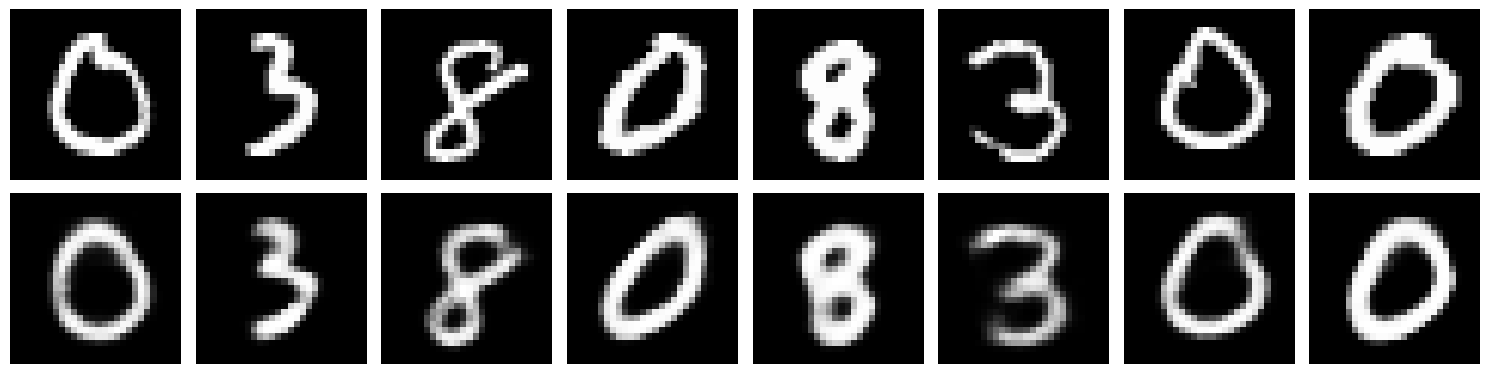

In [21]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, data_loader):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        reconstructed = model(images)

        # Plot original vs reconstructed images
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        for i in range(8):
            # Original images
            axes[0,i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            axes[0,i].axis('off')

            # Reconstructed images
            axes[1,i].imshow(reconstructed[i].cpu().numpy().squeeze(), cmap='gray')
            axes[1,i].axis('off')

        plt.tight_layout()
        plt.show()

# Visualize results
visualize_reconstruction(model, train_loader)

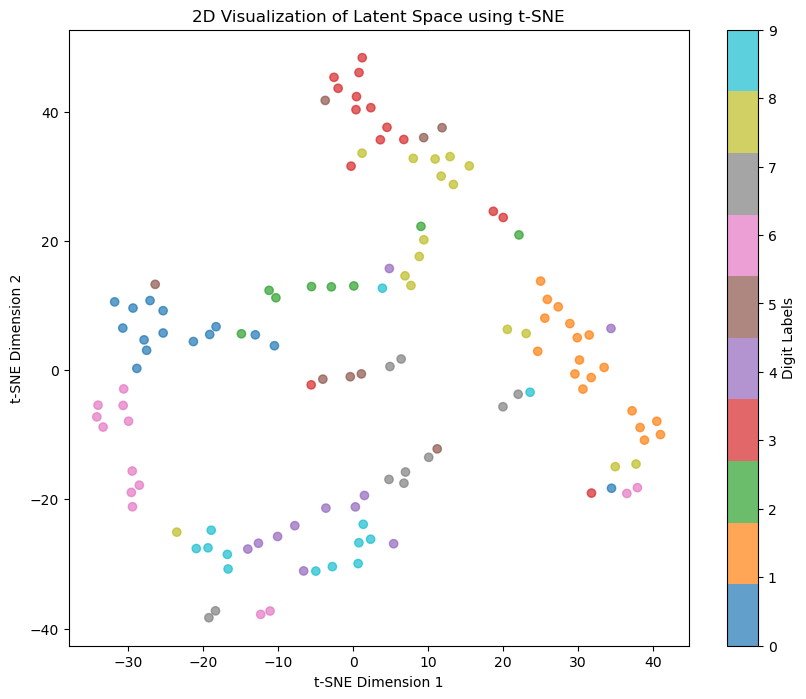

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_space(model, data_loader, n_samples=1000):
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        images, labels = next(iter(data_loader))
        images, labels = images[:n_samples], labels[:n_samples]  # Limit the number of samples
        images = images.to(device)

        # Pass images through encoder to get latent vectors
        latent_vectors = model.encoder(images.view(images.size(0), -1)).cpu().numpy()
        labels = labels.numpy()

    # Apply t-SNE to reduce latent space to 2D, default perplexity = 30
    tsne = TSNE(n_components=2, random_state=42, perplexity=6)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the 2D latent space with labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Digit Labels')
    plt.title('2D Visualization of Latent Space using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Visualize the latent space
visualize_latent_space(model, train_loader)


In [ ]:
from torchinfo import summary

summary(model, input_size=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 20]                 --
│    └─Linear: 2-1                       [128, 400]                314,000
│    └─ReLU: 2-2                         [128, 400]                --
│    └─Linear: 2-3                       [128, 200]                80,200
│    └─ReLU: 2-4                         [128, 200]                --
│    └─Linear: 2-5                       [128, 20]                 4,020
├─Sequential: 1-2                        [128, 784]                --
│    └─Linear: 2-6                       [128, 200]                4,200
│    └─ReLU: 2-7                         [128, 200]                --
│    └─Linear: 2-8                       [128, 400]                80,400
│    └─ReLU: 2-9                         [128, 400]                --
│    └─Linear: 2-10                      [128, 784]               

In [57]:
def Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
    # assuming h=w, so we use the length l
    def conv(l, channels):
        if channels == in_channels:
            return (((l-kernel_size+2*padding)//stride + 1), out_channels)
        else:
            print("Channels do not match")
            raise ValueError
    return conv

def MaxPool2d(kernel_size, stride, padding=0):
    def maxpool(l, channels):
        return (l-kernel_size+2*padding)//stride + 1, channels
    return maxpool

def AvgPool2d(output_size):
    def avgpool(l, channels):
        return output_size, channels
    return avgpool

In [83]:
conv1 = Conv2d(1,32,7, 2, 3)
conv2 = Conv2d(32,16,3, 2, 1)
pool = MaxPool2d(3,2,1)
avgpool = AvgPool2d(output_size=(1, 1))

In [ ]:
conv1 = Conv2d(1,16, 3, padding=1)
conv2 = Conv2d(16,4, 3,padding=1)
pool = MaxPool2d(2, 2)
avgpool = AvgPool2d(output_size=(1, 1))

In [118]:
side = 28; channels = 1
side, channels = conv1(side, channels); print(side, channels)
# side, channels = pool(side, channels); print(side, channels)
side, channels = conv2(side, channels); print(side, channels)
# side, channels = pool(side, channels); print(side, channels)
# side, channels = conv3(side, channels); print(side, channels)
side, channels = avgpool(side, channels); print(side, channels)

14 32
7 16
(1, 1) 16
